# Why do tree-based models still outperform deep learning on tabular data?

Автор: [Денисов Степан](https://t.me/sd_denisoff)

Роль: хакер

___

## Где найти реализацию экспериментов статьи?

Авторы статьи владеют публичным [репозиторием на GitHib](https://github.com/LeoGrin/tabular-benchmark), в котором можно найти все необходимые материалы для экспериментов. Для максимального упрощения воспроизводимости результатов авторы также любезно предоставили датасеты и прочую вспомогательную информацию для обучения.

In [1]:
# !git clone https://github.com/LeoGrin/tabular-benchmark.git

## Пробуем воспроизвести результаты

Сперва скачаем данные, использованные авторами для получения результатов обучения

In [2]:
# %%bash
# pip install openml
# python tabular-benchmark/data/download_data.py

Обучим модели по авторской инструкции

1. Copy / clone this repo on the different machines / clusters you want to use.
2. Login to WandB and create new projects.
3. Enter your projects name in `launch_config/launch_benchmarks.py` (or `launch_config/launch_xps.py`)
4. run `python launch_config/launch_benchmarks.py`
5. Run the generated sweeps using `wandb agent <USERNAME/PROJECTNAME/SWEEPID>` on the machine of your choice. 
More infos
[in the WandB doc](https://docs.wandb.ai/guides/sweeps/quickstart#4.-launch-agent-s)
6. After you've stopped the runs, download the results: `python launch_config/download_data.py`, after entering your wandb
login in `launch_config/download_data.py`.

`FAILED`: Завести обучение из репозитория так и не вышло :( но возможно вскоре станет лучше!

> We're planning to release a version allowing to use Benchopt instead of WandB to make it easier to run.

## Свои соревнования!

Импортируем участников

Для оценки я выбрал 3 модели: RandomForest, CatBoost и TabNet.

- RandomForest - одна из моделей, использовавшаяся в статье. Будем использовать ее для сравнения новыми моделями.
- CatBoost – в представлении не нуждается! Модель градиентного бустинга, выпущенная в 2017 году.
- TabNet – нейросеть от google, выпущенная в 2020 году. Была на целена как раз на то, чтобы превзойти результаты работы древовидных моделей (в том числе CatBoost). Подробнее о модели можно узнать в [оригинальной статье](https://arxiv.org/pdf/1908.07442.pdf) или других обзорных статьях (например, [TabNet: The End of Gradient Boosting?](https://towardsdatascience.com/tabnet-e1b979907694#66f0))

In [3]:
# %pip install pytorch-tabnet

In [4]:
from catboost import CatBoostClassifier, CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [5]:
rf_regr = RandomForestRegressor(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

cb_regr = CatBoostRegressor(verbose=False, random_state=42)
cb_clf = CatBoostClassifier(verbose=False, random_state=42)

tn_regr = TabNetRegressor(verbose=False)
tn_clf = TabNetClassifier(verbose=False)

Определим сетку поиска гиперпараметров способом рандомных итераций, как это было предложено авторами статьи

In [6]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [7]:
rf_random_grid = {
    "n_estimators": [int(x) for x in np.linspace(1, 20, 20)],
    "max_features": ["auto", "sqrt"],
    "max_depth": [int(x) for x in np.linspace(10, 120, 12)],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [1, 3, 4],
}

cb_random_grid = {
    "learning_rate": [0.03, 0.1],
    "depth": [4, 6, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
}

# LIMIT: reduce number of random search iteration due to computational time
n_iter_range = (1, 2)

Соберем все вместе

In [8]:
models = {
    "RandomForest": {
        "name": "rf",
        "grid": rf_random_grid,
        "regr": rf_regr,
        "clf": rf_clf,
    },
    "CatBoost": {
        "name": "cb",
        "grid": cb_random_grid,
        "regr": cb_regr,
        "clf": cb_clf,
    },
    "TabNet": {
        "name": "tn",
        "regr": tn_regr,
        "clf": tn_clf,
    },
}

Загрузим датасеты

In [9]:
import os
import pickle

In [10]:
MAIN_DATA_PATH = "data"

In [11]:
datasets = {
    "numerical_only": {
        "regr": os.listdir(f"{MAIN_DATA_PATH}/numerical_only/regression"),
        "clf": os.listdir(f"{MAIN_DATA_PATH}/numerical_only/balanced"),
    },
    "num_and_cat": {
        "regr": os.listdir(f"{MAIN_DATA_PATH}/num_and_cat/regression"),
        "clf": os.listdir(f"{MAIN_DATA_PATH}/num_and_cat/balanced"),
    },
}

In [12]:
ds_type = "numerical_only"
print(ds_type)
print(f'\t regression: {len(datasets[ds_type]["regr"])}')
print(f'\t classification: {len(datasets[ds_type]["clf"])}')

print()

ds_type = "num_and_cat"
print(ds_type)
print(f'\t regression: {len(datasets[ds_type]["regr"])}')
print(f'\t classification: {len(datasets[ds_type]["clf"])}')

numerical_only
	 regression: 21
	 classification: 16

num_and_cat
	 regression: 14
	 classification: 8


Определим метрики для сравнения моделей

In [13]:
from sklearn.metrics import accuracy_score, r2_score

In [14]:
def evaluate(task_type, y_true, preds):
    if task_type == "regr":
        return r2_score(y_true, preds)
    elif task_type == "clf":
        return accuracy_score(y_true, preds)

Не хватает только отрисовки графика!

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set(style="whitegrid")

In [28]:
def plot_results(results):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    axs[0, 0].set_title(f'Classification ({len(datasets["numerical_only"]["clf"])} datasets)', fontsize=14)
    axs[0, 0].set_ylabel('Test accuracy', fontsize=14)
    for model_name, values in results["numerical_only"]["clf"].items():
        if len(values) == 1:
            values *= len(n_iter_range)
        axs[0, 0].plot(n_iter_range, values, label=model_short_to_long_name[model_name])
    
    axs[0, 1].set_title(f'Regression ({len(datasets["numerical_only"]["regr"])} datasets)', fontsize=14)
    axs[0, 1].set_ylabel('R2 test score', fontsize=14)
    for model_name, values in results["numerical_only"]["regr"].items():
        if len(values) == 1:
            values *= len(n_iter_range)
        axs[0, 1].plot(n_iter_range, values, label=model_short_to_long_name[model_name])
    
    axs[1, 0].set_title(f'Classification ({len(datasets["num_and_cat"]["clf"])} datasets)', fontsize=14)
    axs[1, 0].set_ylabel('Test accuracy', fontsize=14)
    for model_name, values in results["num_and_cat"]["clf"].items():
        if len(values) == 1:
            values *= len(n_iter_range)
        axs[1, 0].plot(n_iter_range, values, label=model_short_to_long_name[model_name])
    
    axs[1, 1].set_title(f'Regression ({len(datasets["num_and_cat"]["regr"])} datasets)', fontsize=14)
    axs[1, 1].set_ylabel('R2 test score', fontsize=14)
    for model_name, values in results["num_and_cat"]["regr"].items():
        if len(values) == 1:
            values *= len(n_iter_range)
        axs[1, 1].plot(n_iter_range, values, label=model_short_to_long_name[model_name])
    
    for ax in axs.reshape(-1):
        ax.set_xlabel('Number of random search iterations', fontsize=14)
        ax.legend()
    
    plt.show()

Ну и еще пару вспомогательных моментов

In [18]:
import warnings

warnings.filterwarnings("ignore")

In [19]:
task_to_ds_folder = {
    "regr": "regression",
    "clf": "balanced",
}

model_short_to_long_name = {
    "rf": "RandomForest",
    "cb": "CatBoost",
    "tn": "TabNet",
}

Запустим обучение

In [20]:
from typing import Literal

from collections import defaultdict
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [21]:
results = {
    "numerical_only": {
        "regr": defaultdict(list),
        "clf": defaultdict(list),
    },
    "num_and_cat": {
        "regr": defaultdict(list),
        "clf": defaultdict(list),
    },
}

In [22]:
def load_dataset(
    ds_type: Literal["numerical_only", "num_and_cat"], 
    ds_path: str
):
    with open(ds_path, "rb") as f:
        if ds_type == "num_and_cat":
            X, y, _ = pickle.load(f)
        else:
            X, y = pickle.load(f)
    return X, y


def aggregate_results(results: list) -> float:
    return np.mean(results)


def train_model(task_type: Literal["reg", "clf"], model, model_meta):
    if task_type == "regr":
        print(f"\t Regression")
    else:
        print(f"\t Classification")

    for n_iter in n_iter_range:
        if model_meta["name"] != "tn":
            best_model = RandomizedSearchCV(
                model, model_meta["grid"], n_iter=n_iter, random_state=42
            )
        else:
            best_model = model

        for ds_type, ds in datasets.items():
            print(f"\t\t {ds_type} data")
            
            res_per_dataset = []

            # LIMIT: reduce number of evaluated datasets due to computational time
            for data in tqdm(ds[task_type][:1], desc=f"n_iter = {n_iter}"):
                if data == ".gitignore":
                    continue

                ds_path = (
                    f"{MAIN_DATA_PATH}/{ds_type}/{task_to_ds_folder[task_type]}/{data}"
                )
                X, y = load_dataset(ds_type, ds_path)

                X_train, X_test, y_train, y_test = train_test_split(
                    X,
                    y,
                    test_size=(1 * 0.3 * 0.7),  # same as in the paper
                    random_state=42,
                )
                
                if model_meta["name"] == "tn" and task_type == "regr":
                    y_train = y_train.reshape(-1, 1)

                best_model.fit(X_train, y_train)
                preds = best_model.predict(X_test)
                res_per_dataset.append(evaluate(task_type, y_test, preds))

            aggregated_res = aggregate_results(res_per_dataset)
            results[ds_type][task_type][model_meta['name']].append(aggregated_res)
            
        if model_meta["name"] == "tn":
            break

In [23]:
for model_group, model_meta in models.items():
    print(model_group)

    task_type = "regr"
    model = model_meta[task_type]
    train_model(task_type, model, model_meta)
    
    task_type = "clf"
    model = model_meta[task_type]
    train_model(task_type, model, model_meta)

RandomForest
	 Regression
		 numerical_only data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 numerical_only data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

	 Classification
		 numerical_only data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 numerical_only data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

CatBoost
	 Regression
		 numerical_only data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 numerical_only data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

	 Classification
		 numerical_only data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 numerical_only data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 2:   0%|          | 0/1 [00:00<?, ?it/s]

TabNet
	 Regression
		 numerical_only data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

	 Classification
		 numerical_only data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

		 num_and_cat data


n_iter = 1:   0%|          | 0/1 [00:00<?, ?it/s]

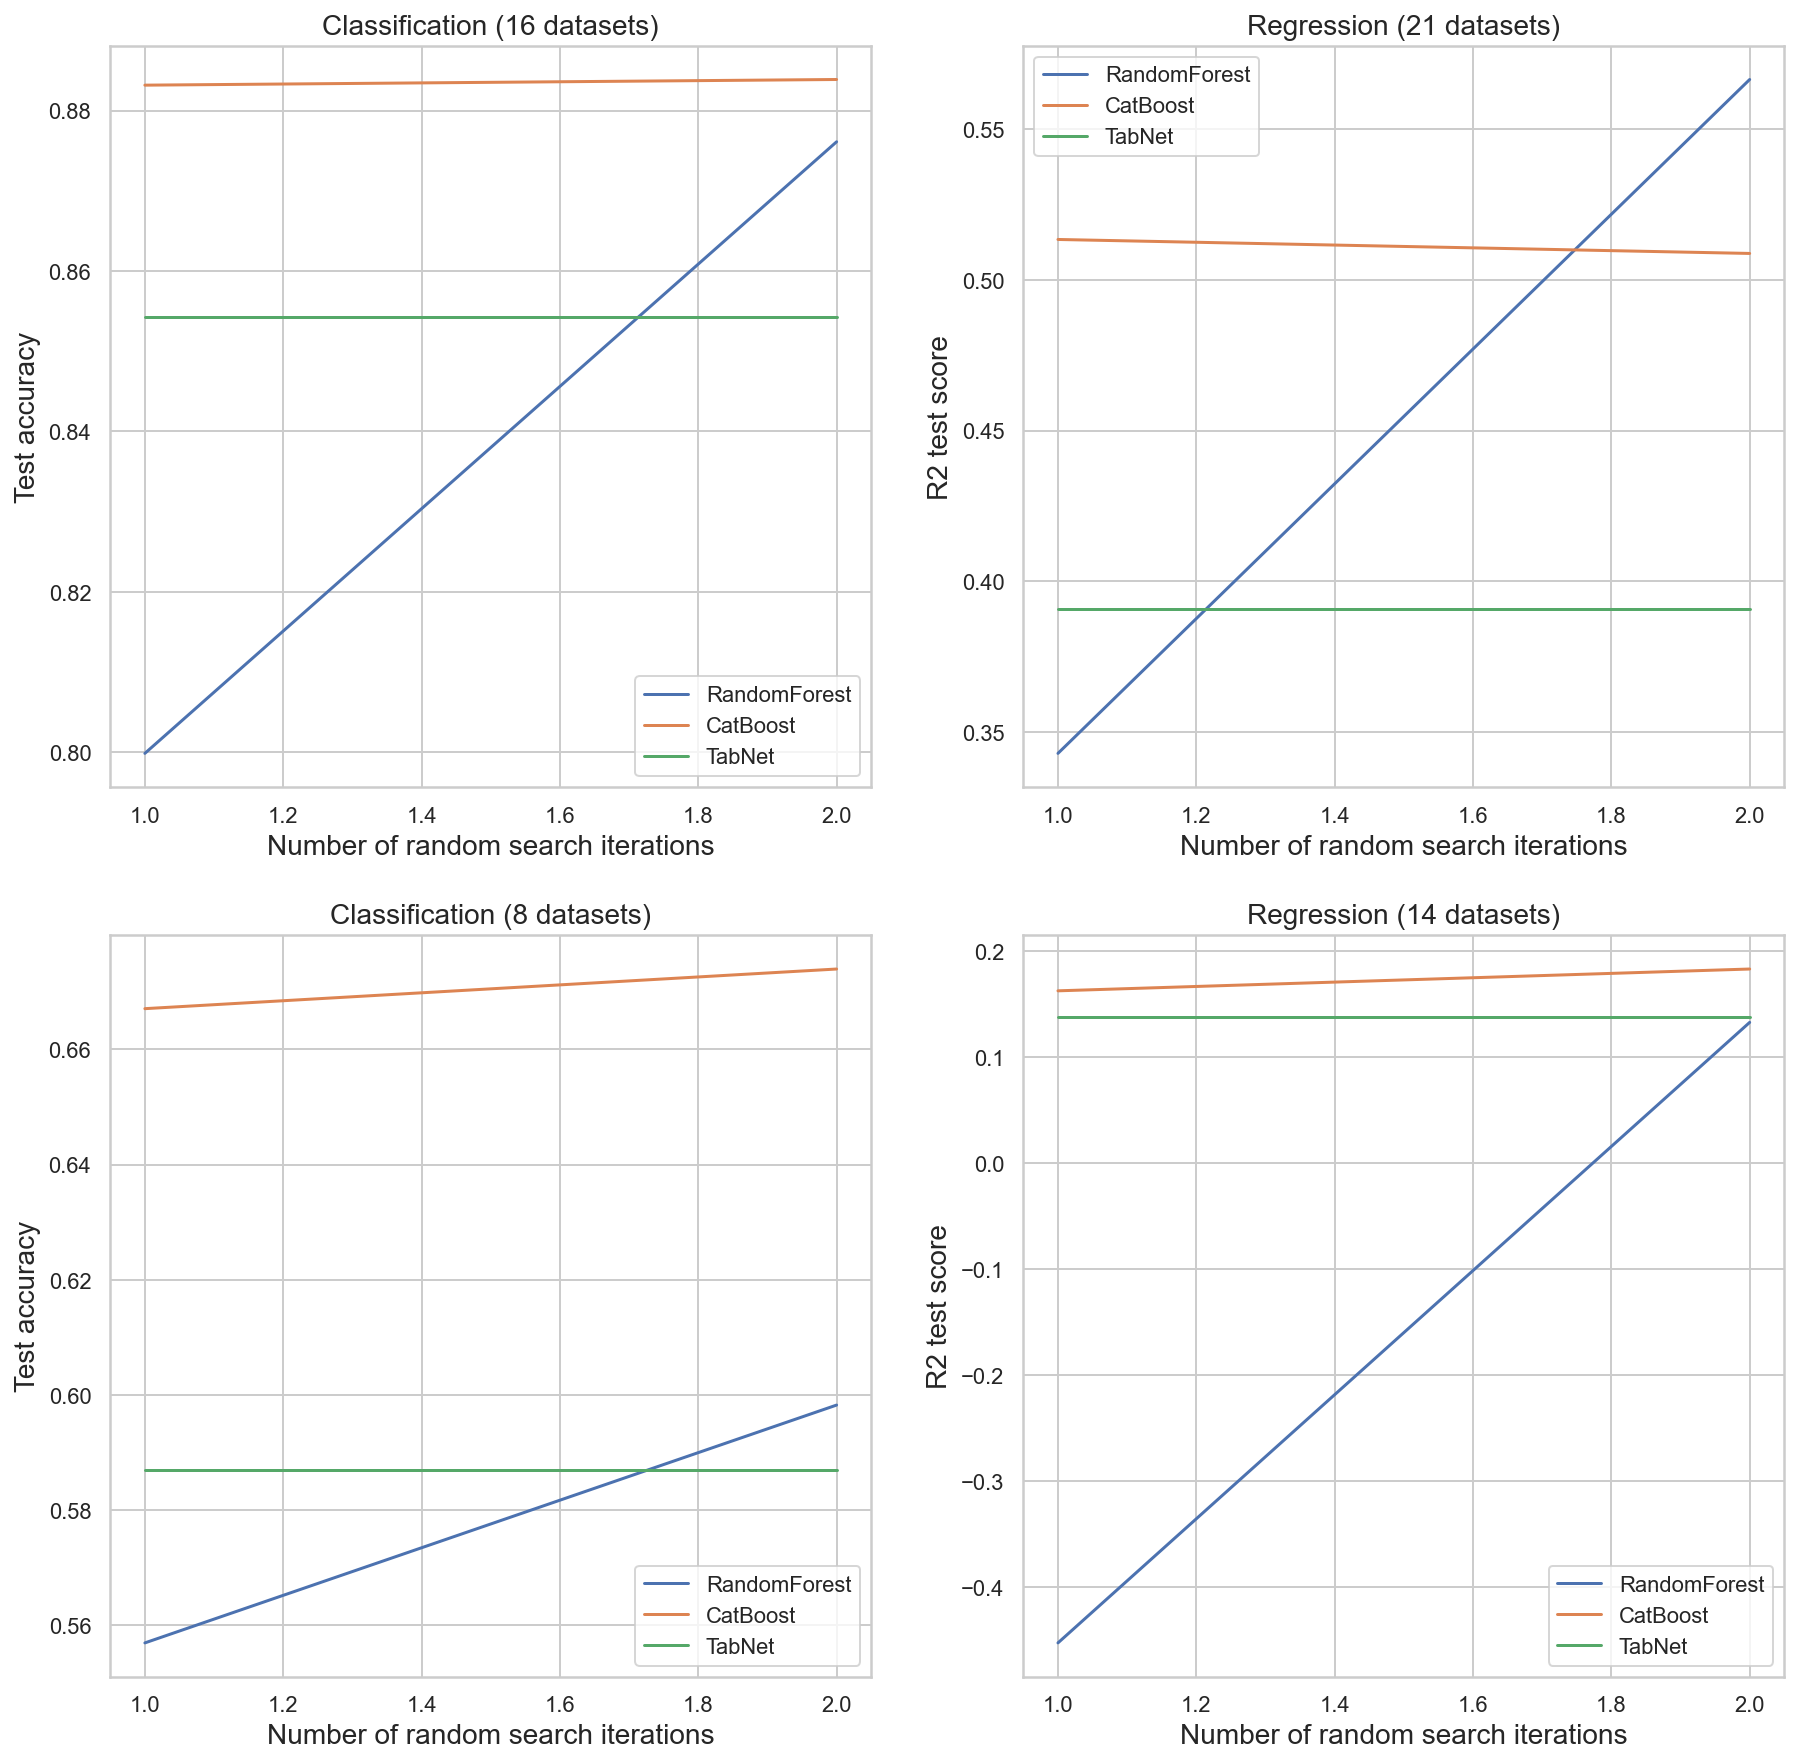

In [29]:
plot_results(results)

Сложно выучить!

- `3` относительно тяжеловесные модели – RandomForest, CatBoost, TabNet
- `2` типа задач – регрессия и классификация
- `2` типа датасетов – numeric_only и num_and_cat
- `много` датасетов для каждого типа задачи и типа датасета (в среднем по 14)
- `много` запусков RandomizedSearchCV

`3 * 2 * 2 * много * много = ∞`